In [1]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, IntegerType,TimestampType
from pyspark.sql.functions import col, hour

In [6]:
# create schema
schema = StructType([ 
    StructField("dt",TimestampType(), True), 
    StructField("lat",DoubleType(), True), 
    StructField("lon",DoubleType(), True), 
    StructField("base", StringType(), True), 
    StructField("cid", IntegerType(), True),
    StructField("id", StringType(), True),
  ])

In [7]:
# read data
spark = SparkSession.builder.appName('Uber').getOrCreate()
path = "hdfs://localhost:9000/Uber_Warehouse/data_warehouse/part-00000-5f603393-be6b-4ef9-abfe-8618e38e8cca-c000.csv"
df = spark.read.csv(path=path, schema=schema)

df.show(5)
df.printSchema()

+-------------------+-------+--------+------+---+----------+
|                 dt|    lat|     lon|  base|cid|        id|
+-------------------+-------+--------+------+---+----------+
|2014-08-01 00:00:00| 40.729|-73.9422|B02598|  2| 2_7299422|
|2014-08-01 00:00:00|40.7476|-73.9871|B02598|  0|0_74769871|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|  0|0_74240044|
|2014-08-01 00:00:00| 40.751|-73.9869|B02598| 13|13_7519869|
|2014-08-01 00:00:00|40.7406|-73.9902|B02598|  0|0_74069902|
+-------------------+-------+--------+------+---+----------+
only showing top 5 rows

root
 |-- dt: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)
 |-- cid: integer (nullable = true)
 |-- id: string (nullable = true)



### 1. Which clusters had the highest number of pickups?

In [9]:
hight_clus = df.groupBy("cid").count().orderBy(col("count").desc())
hight_clus.show(20)

+---+------+
|cid| count|
+---+------+
| 13|187289|
|  0|186818|
| 10|135954|
|  4| 62195|
|  7| 47856|
|  2| 44127|
| 16| 35788|
|  3| 31151|
| 14| 28469|
|  1| 24132|
| 19| 11269|
|  8| 10258|
| 11|  8068|
|  6|  8055|
| 18|  2672|
| 12|  2242|
|  5|  1149|
| 17|   981|
|  9|   493|
| 15|   309|
+---+------+



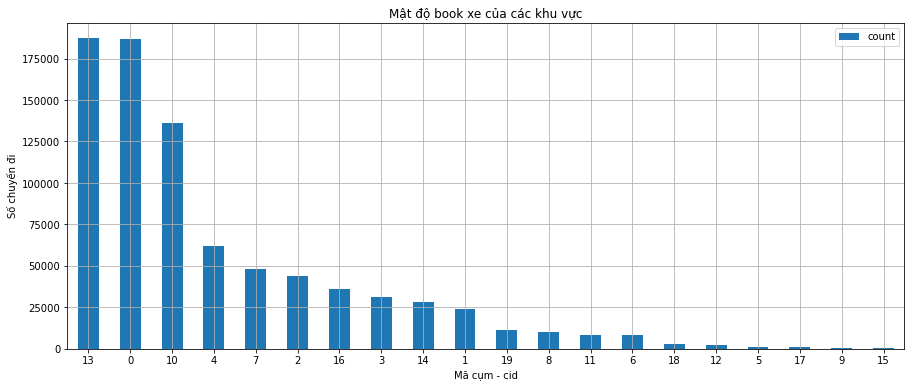

In [10]:
import matplotlib.pyplot as plt
# covert spark df to pandas df
hight_clus_pd = hight_clus.toPandas()

hight_clus_pd.plot.bar(x='cid', y='count', figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Mã cụm - cid")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe của các khu vực");

### 2. Which hours of the day had the highest number of pickups?

In [11]:
hight_hour = df.select(hour("dt").alias("hour")).groupBy("hour").count().orderBy("hour")
hight_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0|21451|
|   1|14471|
|   2|10105|
|   3|10376|
|   4|11774|
|   5|16525|
|   6|24907|
|   7|34064|
|   8|34566|
|   9|30195|
|  10|30706|
|  11|31778|
|  12|32106|
|  13|35764|
|  14|40644|
|  15|48197|
|  16|53481|
|  17|57122|
|  18|55390|
|  19|53008|
|  20|51674|
|  21|51354|
|  22|46008|
|  23|33609|
+----+-----+



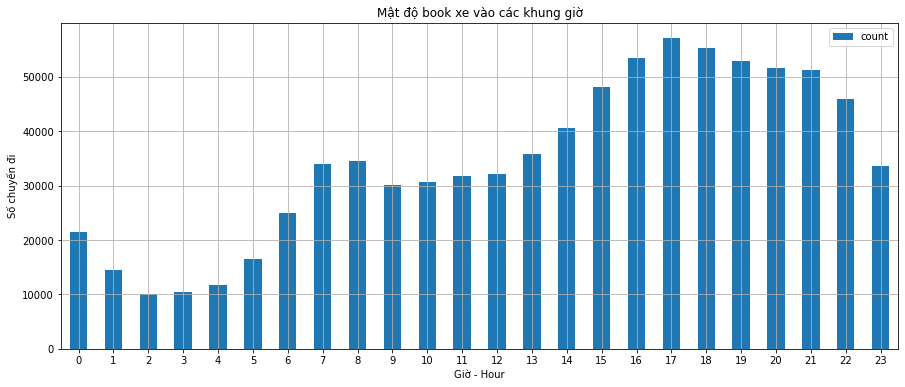

In [12]:
# covert spark df to pandas df
hight_hour_pd = hight_hour.toPandas()

hight_hour_pd.plot.bar(x='hour', y='count', figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe vào các khung giờ");

### 3. Which clusters had the highest number of pickups during morning rush hour?

In [13]:
clus = [0,2,4,7,10,13] # 6 cụm có mật độ cao nhât
hour_mor = [6,7,8,9] # khung giờ buổi sáng

rush_mor = df.select(hour("dt").alias("hour"), "cid").groupBy("hour","cid").count().filter(col("hour").isin(hour_mor) & col("cid").isin(clus)).orderBy("hour", "cid")
rush_mor.show()

+----+---+-----+
|hour|cid|count|
+----+---+-----+
|   6|  0| 5421|
|   6|  2| 1523|
|   6|  4| 2878|
|   6|  7| 1704|
|   6| 10| 3274|
|   6| 13| 4227|
|   7|  0| 7745|
|   7|  2| 1860|
|   7|  4| 4597|
|   7|  7| 2028|
|   7| 10| 4466|
|   7| 13| 6717|
|   8|  0| 8244|
|   8|  2| 1720|
|   8|  4| 4179|
|   8|  7| 2042|
|   8| 10| 4846|
|   8| 13| 7045|
|   9|  0| 6098|
|   9|  2| 1782|
+----+---+-----+
only showing top 20 rows



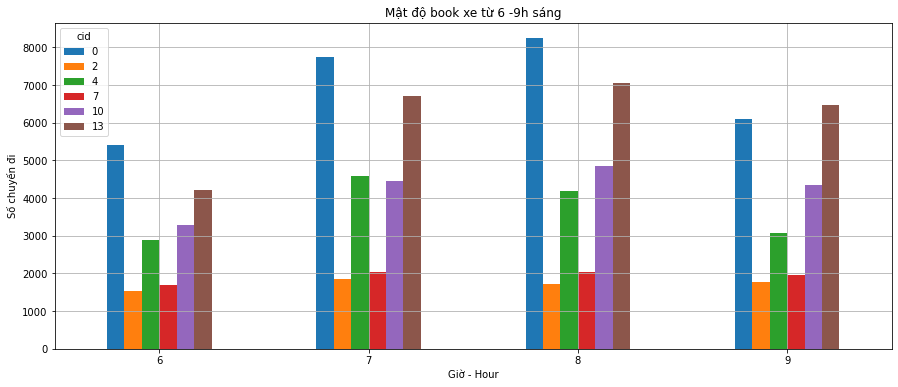

In [14]:
# covert spark df to pandas df
rush_mor_pd = rush_mor.toPandas()
# dùng pivot_table để tổng hợp số cụm và số giờ
rush_mor_pd = rush_mor_pd.pivot_table(index='hour', columns='cid', values='count')

rush_mor_pd.plot.bar(figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe từ 6 -9h sáng");

### 4. Which clusters had the highest number of pickups during afternoon rush hour?

In [15]:
hour_aft = [15,16,17,18] # khung giờ buổi chiều

rush_aft = df.select(hour("dt").alias("hour"), "cid").groupBy("hour","cid").count().filter(col("hour").isin(hour_aft) & col("cid").isin(clus)).orderBy("hour", "cid")
rush_aft.show()

+----+---+-----+
|hour|cid|count|
+----+---+-----+
|  15|  0|10530|
|  15|  2| 1877|
|  15|  4| 3437|
|  15|  7| 2335|
|  15| 10| 8149|
|  15| 13|12952|
|  16|  0|11904|
|  16|  2| 1955|
|  16|  4| 3712|
|  16|  7| 2575|
|  16| 10| 9182|
|  16| 13|15164|
|  17|  0|13043|
|  17|  2| 2297|
|  17|  4| 3996|
|  17|  7| 3018|
|  17| 10| 9954|
|  17| 13|15501|
|  18|  0|12479|
|  18|  2| 2575|
+----+---+-----+
only showing top 20 rows



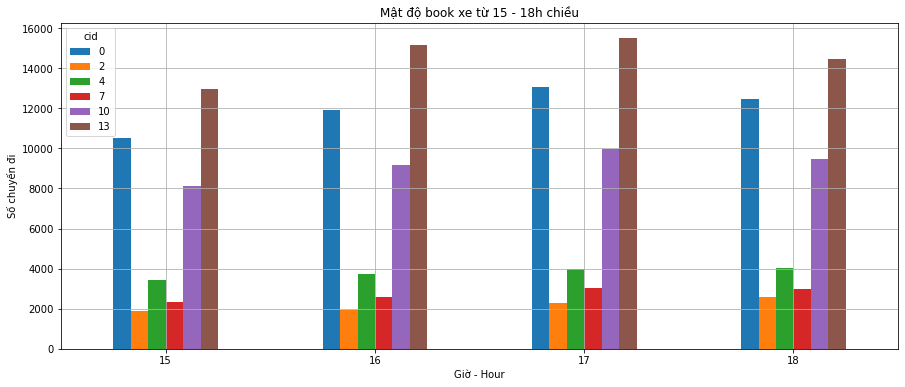

In [16]:
# covert spark df to pandas df
rush_aft_pd = rush_aft.toPandas()
# dùng pivot_table để tổng hợp số cụm và số giờ
rush_aft_pd = rush_aft_pd.pivot_table(index='hour', columns='cid', values='count')

rush_aft_pd.plot.bar(figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe từ 15 - 18h chiều");

### 5. Which clusters had the highest number of pickups during evening rush hour?

In [17]:
hour_eve = [19,20,21,22,23] # khung giờ buổi tối

rush_eve = df.select(hour("dt").alias("hour"), "cid").groupBy("hour","cid").count().filter(col("hour").isin(hour_eve) & col("cid").isin(clus)).orderBy("hour", "cid")
rush_eve.show()

+----+---+-----+
|hour|cid|count|
+----+---+-----+
|  19|  0|11607|
|  19|  2| 2543|
|  19|  4| 3399|
|  19|  7| 2861|
|  19| 10| 9425|
|  19| 13|13439|
|  20|  0|11510|
|  20|  2| 2630|
|  20|  4| 3019|
|  20|  7| 3149|
|  20| 10| 8930|
|  20| 13|12262|
|  21|  0|12006|
|  21|  2| 2799|
|  21|  4| 2644|
|  21|  7| 3254|
|  21| 10| 8915|
|  21| 13|11175|
|  22|  0|11575|
|  22|  2| 2748|
+----+---+-----+
only showing top 20 rows



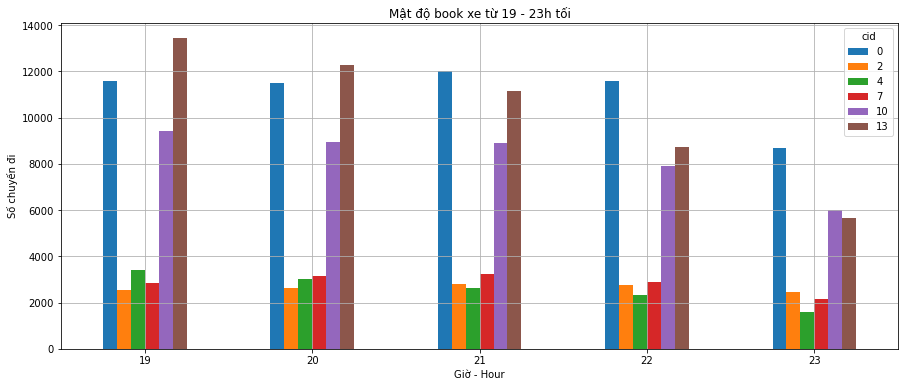

In [18]:
# covert spark df to pandas df
rush_eve_pd = rush_eve.toPandas()
# dùng pivot_table để tổng hợp số cụm và số giờ
rush_eve_pd = rush_eve_pd.pivot_table(index='hour', columns='cid', values='count')

rush_eve_pd.plot.bar(figsize=(15,6), rot=0)
plt.grid()
plt.xlabel("Giờ - Hour")
plt.ylabel("Số chuyến đi")
plt.title("Mật độ book xe từ 19 - 23h tối");

## Conclusion

- Cụm 13 là cụm có mật độ book xe cao nhất
- Thời gian từ 16 - 19 giờ có mật độ book xe cao nhất
- Cụm 13 và Cụm 0 có mật độ book xe gần bằng nhau chỉ hơn kém nhau khoảng 900 lượt book với cụm 13 là 187289 và cụm 0 là 186818